In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

from jax.random import PRNGKey, split
from jax import config
config.update("jax_enable_x64", True)
from tqdm import tqdm

from data import generate_data
from loss import create_loss
from network import init_net, compute_end_to_end, compute_factor
from solver import train
from utils import compose, svd, compute_angle, compute_svd_series
from plot import plot_series

In [3]:
key = PRNGKey(0)

input_dim = 30
output_dim = 30
rank = 3
depth = 3
init_type = "orth"
init_scale = 1

key, subkey = split(key)
target = generate_data(key=subkey, shape=(output_dim, input_dim), rank=rank)

key, subkey = split(key)
init_weights = init_net(
    key=subkey, 
    input_dim=input_dim, 
    output_dim=output_dim,
    width=input_dim,
    depth=depth,
    init_scale=init_scale
)

loss_fn = create_loss(target)

loss_fn_dict = {
    'train': loss_fn
}
network_fn = compute_end_to_end

In [4]:
n_outer_loops = 50
step_size = 1
result = train(
    init_weights=init_weights,
    network_fn=network_fn,
    loss_fn_dict=loss_fn_dict,
    n_outer_loops=n_outer_loops,
    step_size=step_size,
    save_weights=True,
    n_inner_loops=1
)

  0%|          | 0/50 [00:00<?, ?it/s]

In [5]:
series_list = []

for layer in range(depth):
    series_list.append(compute_svd_series(result['weights'], layer, rank))

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 374.98it/s]


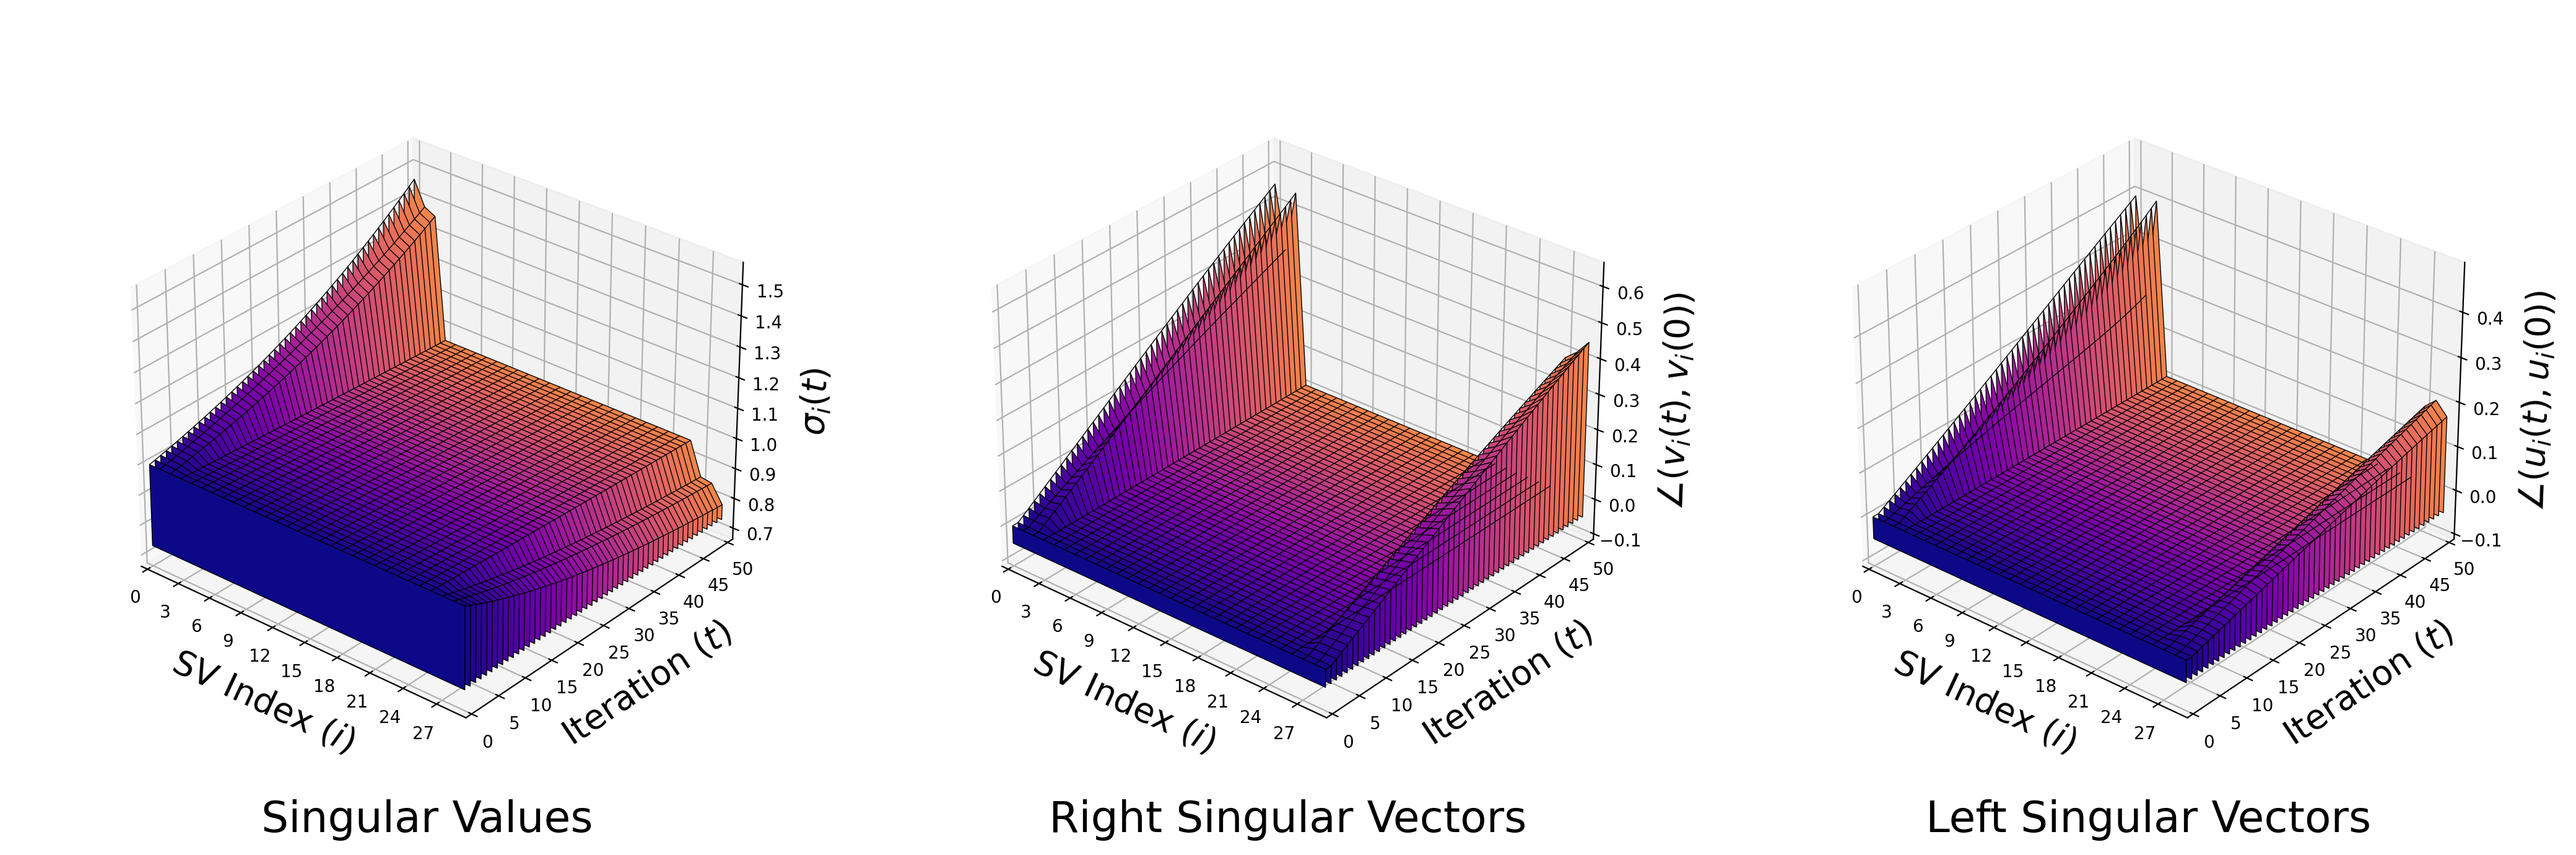

In [25]:
sval_series, right_series, left_series = series_list[0]

fig = plt.figure(figsize=(21, 7))
ax = fig.add_subplot(131, projection='3d')
plot_series(ax, sval_series, color="plasma", crossing_lines=True, linewidth=0.5, alpha=1.0)

ax.set_xlabel('\nSV Index ($i$)', fontsize=20)
ax.set_ylabel('\nIteration ($t$)', fontsize=20)
ax.set_zlabel('\n$\sigma_i(t)$', fontsize=20)

ax.set_title('Singular Values', fontsize=25, y=0.0)

ax = fig.add_subplot(132, projection='3d')

plot_series(ax, right_series, color="plasma", crossing_lines=True, linewidth=0.5, alpha=1.0)

ax.set_xlabel('\nSV Index ($i$)', fontsize=20)
ax.set_ylabel('\nIteration ($t$)', fontsize=20)
ax.set_zlabel('\n' + r'$\angle(v_i(t), v_i(0))$', fontsize=20)

ax.set_title('Right Singular Vectors', fontsize=25, y=0.0)

ax = fig.add_subplot(133, projection='3d')

plot_series(ax, left_series, color="plasma", crossing_lines=True, linewidth=0.5, alpha=1.0)

ax.set_xlabel('\nSV Index ($i$)', fontsize=20)
ax.set_ylabel('\nIteration ($t$)', fontsize=20)
ax.set_zlabel('\n' + r'$\angle(u_i(t), u_i(0))$', fontsize=20)

ax.set_title('Left Singular Vectors', fontsize=25, y=0.0)

plt.tight_layout()
plt.savefig('figs/thm_main.png', dpi=500, bbox_inches='tight')

## Supplement

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(21, 24))
subfigs = fig.subfigures(nrows=3, ncols=1)
for i, subfig in enumerate(subfigs):
    sval_series, right_series, left_series = series_list[i]
    subfig.suptitle(f'Layer {i+1}', fontsize=40, weight='bold', y=0.92)
    ax = subfig.add_subplot(131, projection='3d')
    plot_sv_series(ax, sval_series)

    ax.set_xlabel('\nSV Index ($i$)', fontsize=20)
    ax.set_ylabel('\nIteration ($t$)', fontsize=20)
    ax.set_zlabel('\n$\sigma_i(t)$', fontsize=20)

    ax.set_title('Singular Values', fontsize=25, y=0.0)

    ax = subfig.add_subplot(132, projection='3d')

    plot_sv_series(ax, right_series, color='inferno')

    ax.set_xlabel('\nSV Index ($i$)', fontsize=20)
    ax.set_ylabel('\nIteration ($t$)', fontsize=20)
    ax.set_zlabel('\n' + r'$\angle(v_i(t), v_i(0))$', fontsize=20)

    ax.set_title('Right Singular Vectors', fontsize=25, y=0.0)

    ax = subfig.add_subplot(133, projection='3d')

    plot_sv_series(ax, left_series, color='cividis')

    ax.set_xlabel('\nSV Index ($i$)', fontsize=20)
    ax.set_ylabel('\nIteration ($t$)', fontsize=20)
    ax.set_zlabel('\n' + r'$\angle(u_i(t), u_i(0))$', fontsize=20)

    ax.set_title('Left Singular Vectors', fontsize=25, y=0.0)

# plt.tight_layout()
# plt.savefig('figs/thm_sup.png', dpi=300, bbox_inches='tight')